### Lake Taupo

**Station Name:** tgho 

**Location:** North Island, New Zealand

**Archive:** [Geonet](https://www.geonet.org.nz/)

**DOI:**  	N/A

**Ellipsoidal Coordinates:**

- Latitude: -38.813

- Longitude: 175.996

- Height: -38.813 m

[Station Page at Geonet](https://www.geonet.org.nz/data/network/mark/TGHO)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/TGHO.sta)

[Google Map Link](https://goo.gl/maps/1zmgi6rRHPVPDAfV8)

<p align="center">
<img src="../../data/tgho_barker.jpeg" width="500"><BR>
Photo credit: Simon Barker
</P>

### Data Summary

Station tgho is operated by GNS in new zeland and the site site is located 
on a platform in Lake Taupo, new zealand. It records standard GPS and Glonass signals at a low sample rate of 30 sec.

### Imports

In [1]:
import os
import sys
import re
import json
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");
import matplotlib.pyplot as plt

# We are including our repository bin to the system path so that we can import the following python modules
bin_path = os.path.abspath(os.path.join('../../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import run_gnssrefl 
import gnssrefl_helpers

%matplotlib inline

In [2]:
#Making sure environment variables are set - this is required to run the gnssrefl code
exists = gnssrefl_helpers.check_environment()
if exists == False:
    gnssrefl_helpers.set_environment()
        
refl_code_loc = os.environ['REFL_CODE']
# import the crx2rnx file which is dependant on your working OS - this is required to run the gnssrefl code
gnssrefl_helpers.download_crx2rnx()

environment variable ORBITS set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe


In [3]:
# This is only for these use cases - you can set pltscreen=True in quicklook to print these plots as well
def pretty_plots(station, values, frequency,metrics=None):
    # plotting the quicklook graph periodograms
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10), sharex=True)
    fig.suptitle(f'QuickLook: {station},{frequency}', size=16)

    quadrants = ['NW', 'NE', 'SW', 'SE']
    quadrant_labels = ['Northwest','Northeast', 'Southwest', 'Southeast']

    for i, ax in enumerate(axes.flat):
        quad = quadrants[i]
        for fail_satellite in values[f'f{quad}']:
            g = sns.lineplot(x=values[f'f{quad}'][fail_satellite][0],
                             y=values[f'f{quad}'][fail_satellite][1],
                             ax=ax, color='lightgrey')
        for satellite in values[quad]:
            g = sns.lineplot(x=values[quad][satellite][0],
                             y=values[quad][satellite][1],
                             ax=ax)
        g.set_title(quadrant_labels[i])
        g.set_ylabel('volts/volts')
        g.set_xlabel('reflector height (m)')

    if metrics:
        success, fail = gnssrefl_helpers.quicklook_metrics(metrics)
        fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
        fig.suptitle(f'QuickLook Retrieval Metrics: {station}, {frequency}', size=16)

        for i, ax in enumerate(axes):
            g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
            g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')

        axes[0].legend(loc='upper right')

        avg_rh = np.mean(success['Reflector Height'])
        print(f'Average reflector height value: {avg_rh:.1f}')

    plt.tight_layout()
    plt.show()

### Take a Quick Look at the Data

We will begin like always by making an **SNR** file. Here we will use both GPS and Glonass and we'll set the archive to nz

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/tgho/tgho3000.20.snr66
minimum elevation angle (degrees) for this dataset:  0.0233
Average reflector height value: 3.7


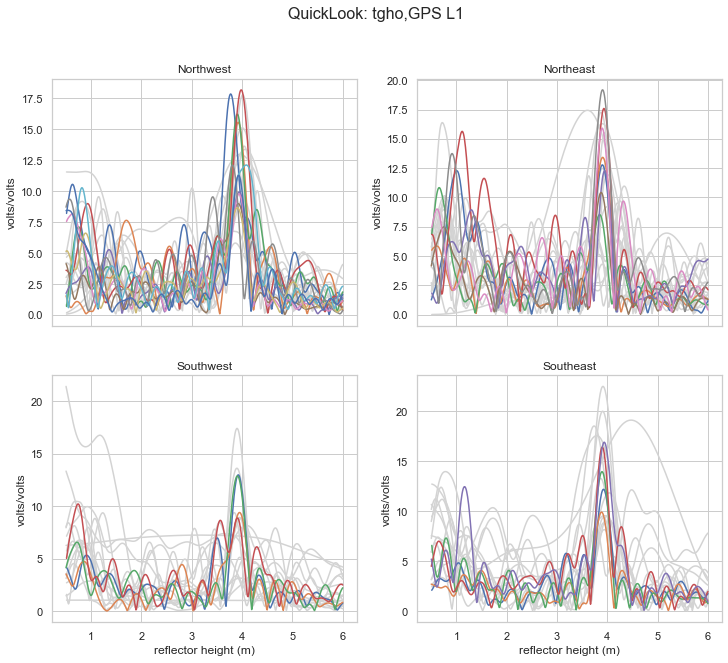

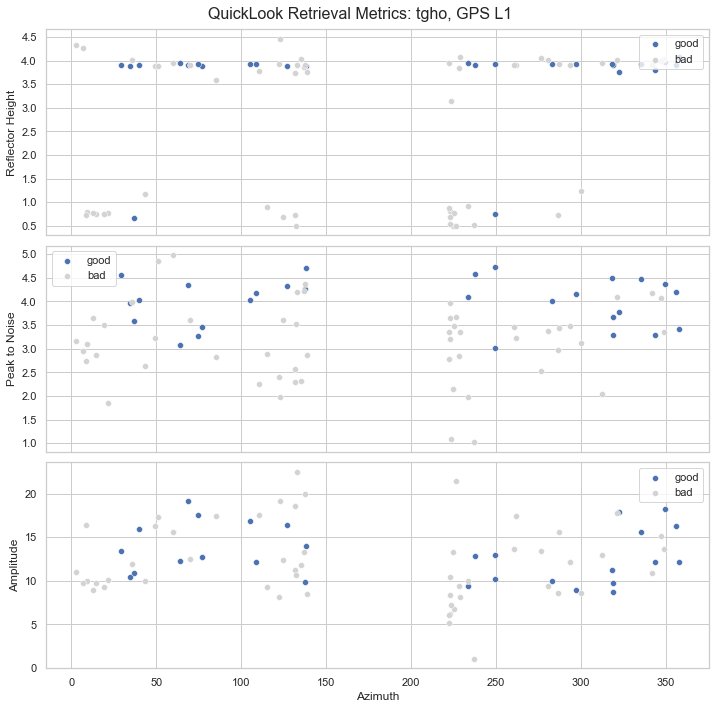

In [4]:
station = 'tgho'
# picking a year and day of year
year=2020
doy=300

lat = -38.8130
long = 175.9960
height = 385.990


run_gnssrefl.rinex2snr(station=station, year=year, doy=doy, orb='gnss', archive='nz')

values, metrics = run_gnssrefl.quicklook(station, year, doy=doy)
pretty_plots(station, values, 'GPS L1', metrics)

 Using the default elevation angles is likely combining water and pier reflections so we will try restricting the close reflections (from the pier) by using a larger lower bound. Let's compare the defaults with 5-15 degrees elevation angles instead of 5-25 to see if this improves the retrievals.

minimum elevation angle (degrees) for this dataset:  0.0233
Average reflector height value: 3.9


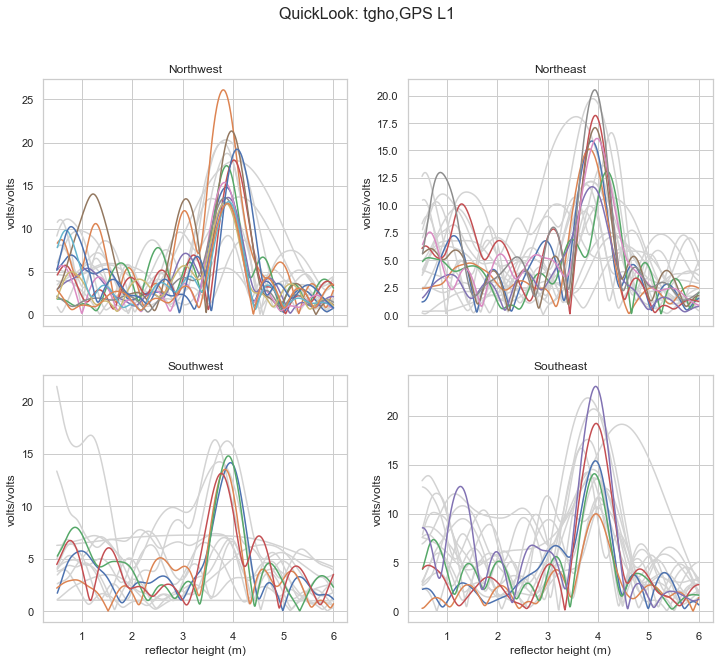

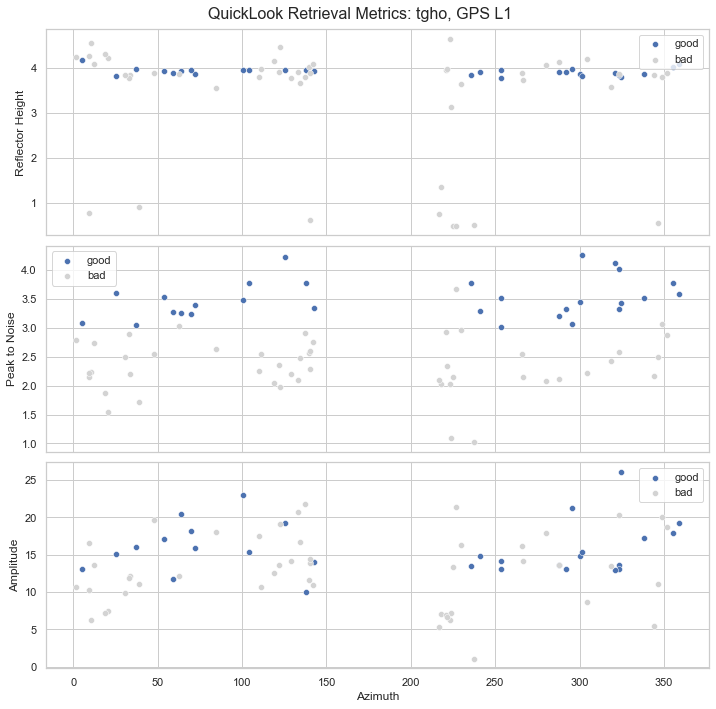

In [5]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, e2=15)

pretty_plots(station, values, 'GPS L1', metrics)

This does look better. It's possible that the clutter near the monument produces noise at the smaller RH values. A better result can be found if those values are eliminated by setting heights from 2 through 8.

minimum elevation angle (degrees) for this dataset:  0.0233


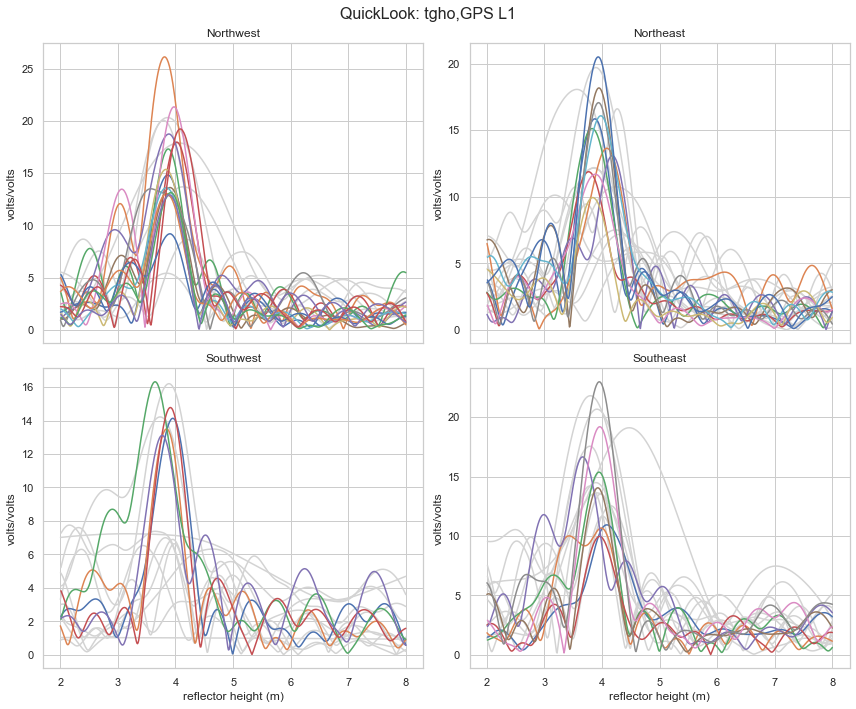

In [6]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, e1=5, e2=15, h1=2, h2=8)
pretty_plots(station, values, 'GPS L1')

We'll keep in mind from the qc plots here that we'll probably choose our amplitude to be ~9 and our peak to noise ratio to 3.

Now let's try looking at the periodograms for L2:

minimum elevation angle (degrees) for this dataset:  0.0233


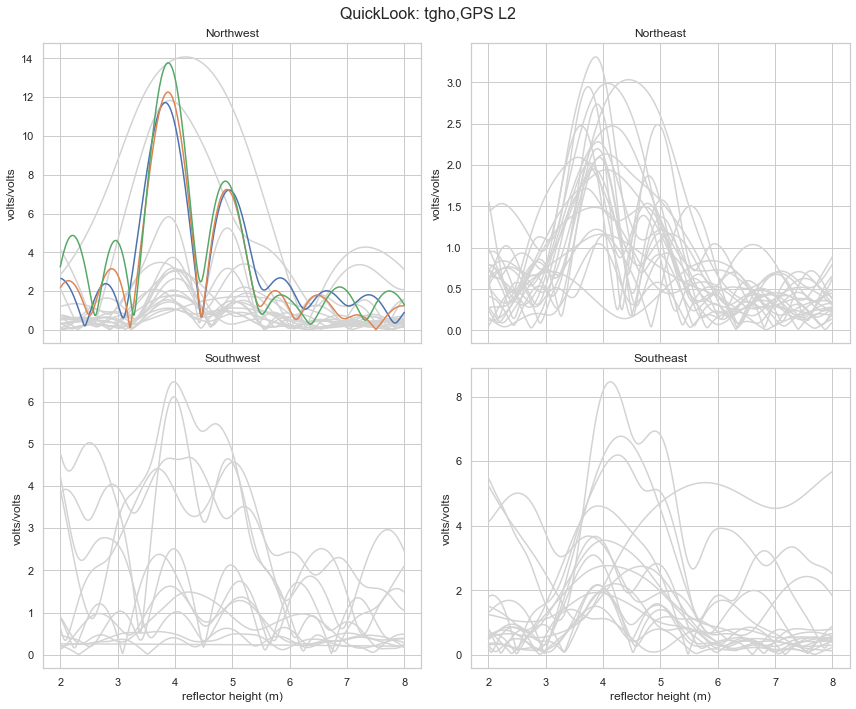

In [7]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, e1=5, e2=15, h1=2, h2=8, f=2)
pretty_plots(station, values, 'GPS L2')

This shows us that we will not use L2 data in the analysis.

Next, we'll look at the Glonass frequencies:101 (L1) and 102 (L2)

minimum elevation angle (degrees) for this dataset:  0.0233
Average reflector height value: 3.9


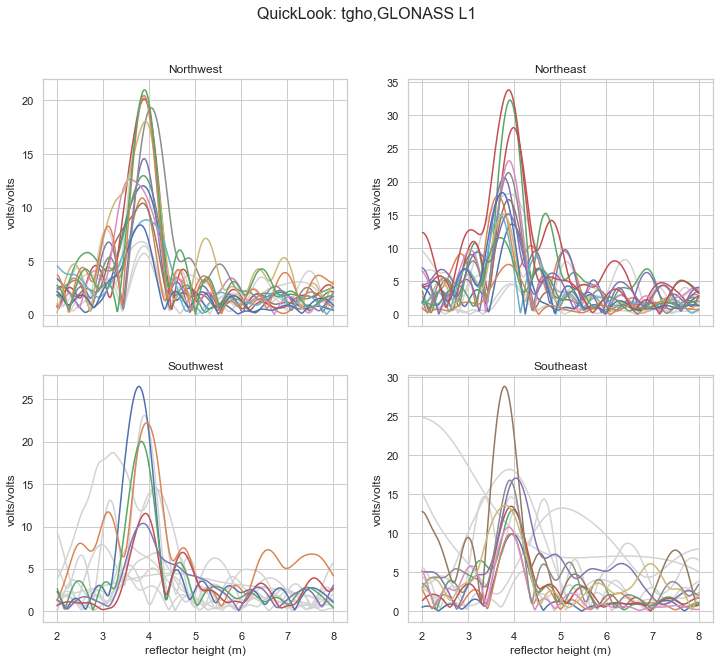

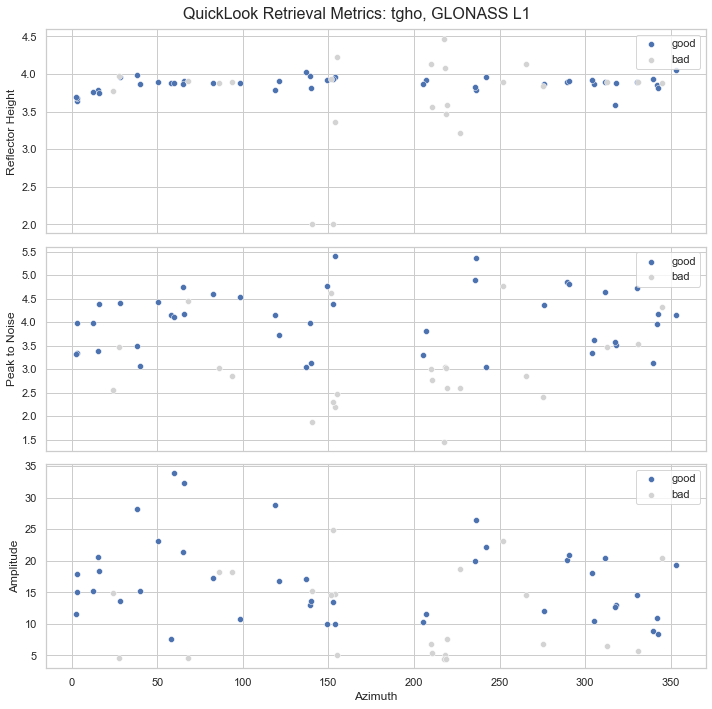

minimum elevation angle (degrees) for this dataset:  0.0233


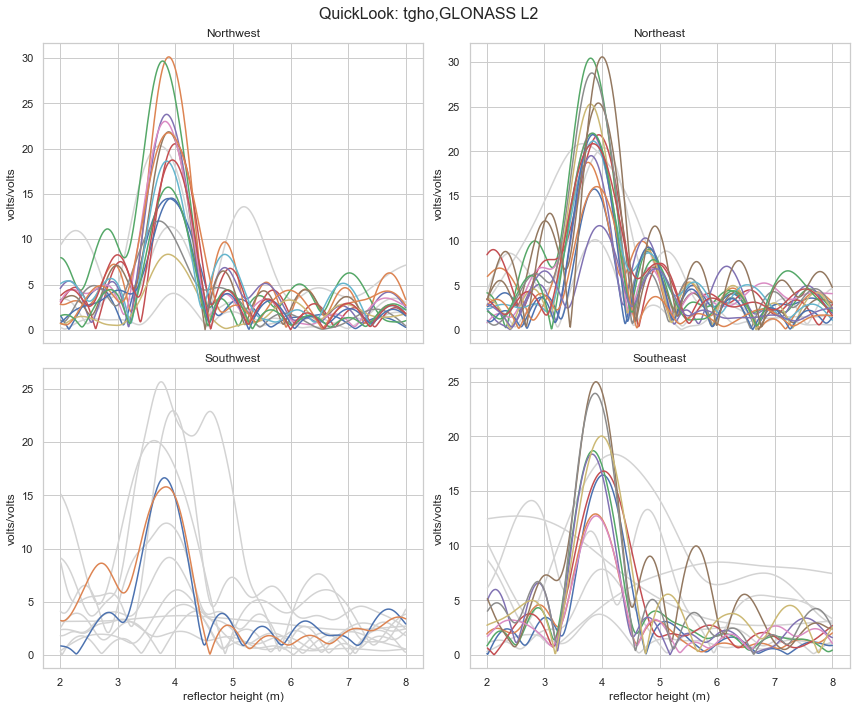

In [8]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, e1=5, e2=15, h1=2, h2=8, f=101)
pretty_plots(station, values, 'GLONASS L1', metrics)

values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, e1=5, e2=15, h1=2, h2=8, f=102)
pretty_plots(station, values, 'GLONASS L2')

We're going exclude 135-225 degrees in azimuth as there is an empty region as well as a few poor retreivals.

A windy day could cause bad retrievals.  For days with no wind, we would have large amplitudes - and for very windy days it could look like this:

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/tgho/tgho2730.20.snr66
minimum elevation angle (degrees) for this dataset:  0.0001
Average reflector height value: 4.1


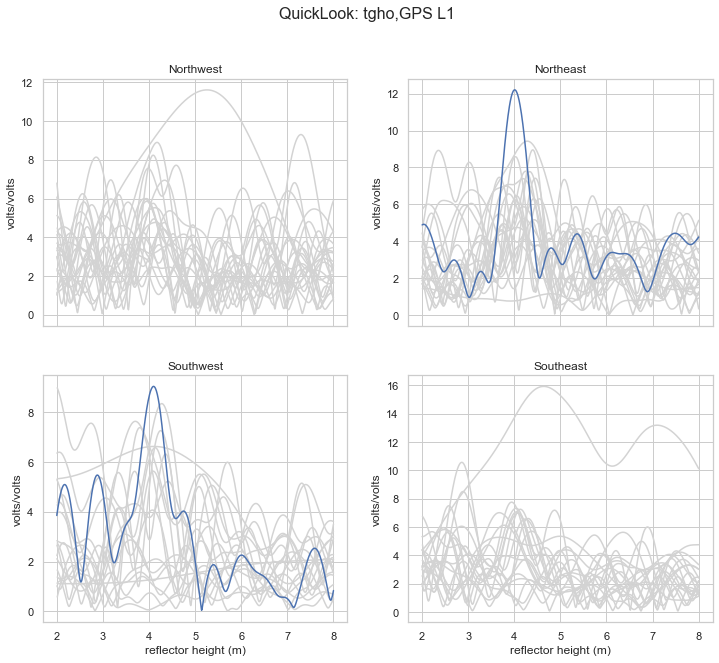

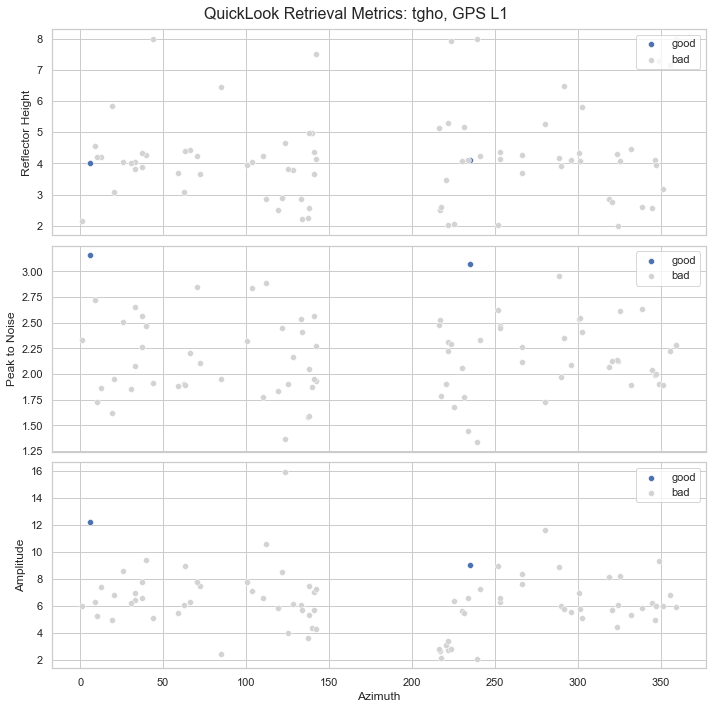

In [9]:
#station = 'tgho'
# picking a year and day of year
year=2020
doy=273 #sep 29

run_gnssrefl.rinex2snr(station=station, year=year, doy=doy, archive='nz')

values, metrics = run_gnssrefl.quicklook(station, year=year, doy=doy, e1=5, e2=15, h1=2, h2=8)
pretty_plots(station, values, 'GPS L1', metrics)

### Analyze the Data
Here we'll set the values we discussed as variables and will pass them into the make json function.

In [10]:
min_elevation_angle = 5
max_elevation_angle = 15
peak_to_noise = 3
amplitude = 9
min_height = 2
max_height = 8
run_gnssrefl.make_json(station, lat, long, height, e1=min_elevation_angle, e2=max_elevation_angle,
                       peak2noise=peak_to_noise, ampl=amplitude, h1=min_height, h2=max_height)

# This is the json file that was created with the defaults/parameters you set above
json_file = f'{refl_code_loc}/input/{station}.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    
file

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/tgho.json


{'station': 'tgho',
 'lat': -38.813,
 'lon': 175.996,
 'ht': 385.99,
 'minH': 2,
 'maxH': 8,
 'e1': 5,
 'e2': 15,
 'NReg': [2, 8],
 'PkNoise': 3,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [9, 9, 9],
 'refraction': None,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'tgho_lsp.png',
 'delTmax': 75}

The azimuth mask has to be set by hand again, and we will add the glonass signals (frequencies 101 and 102), and remove GPS L2 and L5 signals.

In [11]:
# Now lets edit the json file
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    
# Here is where we can 'hand edit' values in the json file
# lets edit the azimuths. We set these values by looking at the metrics qc plot above
file['azval'] = [0,90,90,135,225,270,270,360]
file['freqs'] = [1, 101, 102]
os.remove(json_file)

with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
# now lets view it again and note the difference
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'tgho',
 'lat': -38.813,
 'lon': 175.996,
 'ht': 385.99,
 'minH': 2,
 'maxH': 8,
 'e1': 5,
 'e2': 15,
 'NReg': [2, 8],
 'PkNoise': 3,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 135, 225, 270, 270, 360],
 'freqs': [1, 101, 102],
 'reqAmp': [9, 9, 9],
 'refraction': None,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'tgho_lsp.png',
 'delTmax': 75}

Now we would run rinex2snr for about six months in 2020 and then run gnssir for the same dates.

In [ ]:
# get snr (let's use GFZ orbits, which is multi-GNSS setting orb='gnss')
run_gnssrefl.rinex2snr(station, year, doy=130, doy_end=319, orb='gnss', archive='nz')

Now run gnssir:

In [ ]:
run_gnssrefl.gnssir(station, year, doy=130, doy_end=319)

To look at daily averages, use the utility <code>daily_avg</code>. The median filter is set to allow values within 0.25 meters of the 
median, and the minimum number of tracks required to calculate the average we will set to 50 tracks. We can also set our own name for the daily average file.

In [12]:
run_gnssrefl.daily_avg(station, medfilter=.25, ReqTracks=50, plt2screen=False,
                       txtfile=f'{station}-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/tgho_allRH.txt
Number of files in  2020 174
not enough retrievals on  2020 9 18 34
not enough retrievals on  2020 10 3 22
not enough retrievals on  2020 9 17 44
not enough retrievals on  2020 9 4 32
not enough retrievals on  2020 9 16 49
not enough retrievals on  2020 9 26 42
not enough retrievals on  2020 11 5 44
not enough retrievals on  2020 9 27 12
not enough retrievals on  2020 9 15 6
not enough retrievals on  2020 9 29 11
not enough retrievals on  2020 9 28 1
not enough retrievals on  2020 6 8 37
not enough retrievals on  2020 6 7 28
not enough retrievals on  2020 6 19 10
not enough retrievals on  2020 6 6 38
not enough retrievals on  2020 7 22 19
not enough retrievals on  2020 7 16 41
not enough retrievals on  2020 7 23 14
not enough retrievals on  2020 8 21 50
not enough retrievals on  2020 5 22 45
not enough retrievals on  2020 6 3 5
not enough retrievals on  2020 7 15 27
not enough retrievals 

Now we can plot all of the reflector heights:

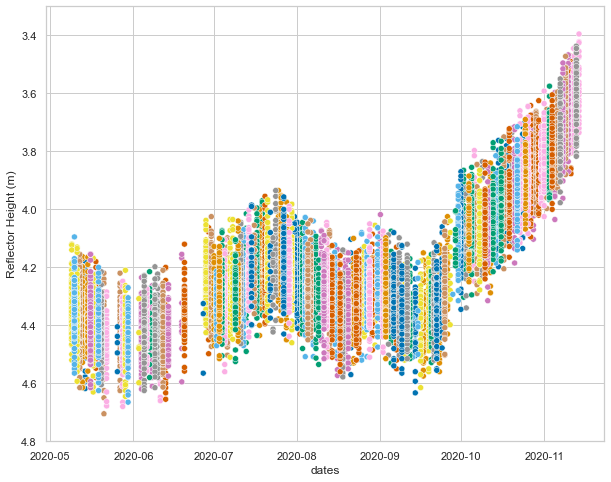

In [13]:
filepath = f'{refl_code_loc}/Files/{station}_allRH.txt'
data = gnssrefl_helpers.read_rh_files(filepath)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim(4.8,3.3)
g.set_ylabel('Reflector Height (m)');

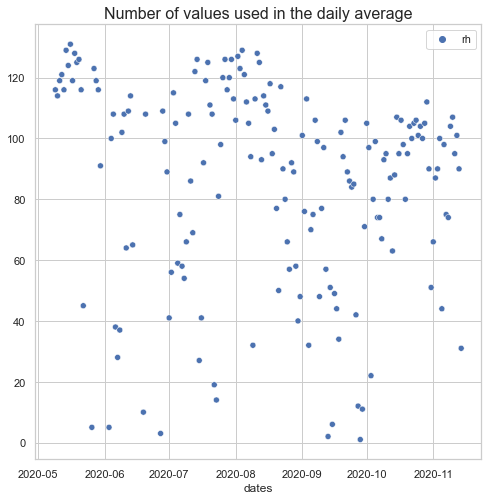

In [14]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

Finally, the daily average RH plot:

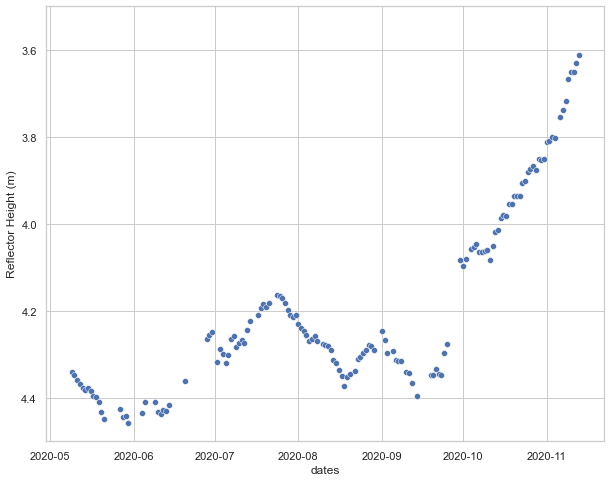

In [15]:
filepath = f'{refl_code_loc}/Files/{station}-dailyavg.txt'
data = gnssrefl_helpers.read_rh_files(filepath)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(4.5,3.5)
g.set_ylabel('Reflector Height (m)');

and now we can see the reflector heights for these 6 months in 2020.

We'll note that there are quite a few data outages in this series, which means the RINEX files were missing from the NZ archive.

Although Taupo is in a volcanic caldera, lake levels are determined by seasonal processes such 
as evaporation, precipitation, input from local drainages, and outflow. The Waikoto 
River is sole river draining the lake, and river flow is regulated by a series of hydroelectric dams.